# 1. 기본설정
## (1) 라이브러리

In [1]:
########################### 1. 기본 설정 ##########################
import time
start_time = time.time()

import os

import pandas as pd
import numpy as np
import copy

######################### 2. 데이터 전처리 ########################
### (1) 이미지 데이터 증강 

from PIL import Image
from PIL import ImageFilter
from matplotlib import pyplot as plt
import tensorflow_hub as hub

import math

#################### 3. 모델 학습 및 결과 검증 ####################
### (1) 모델 설계 및 대표 벡터 추출 

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, concatenate
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

### (2) 분류 예측 

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.cluster import KMeans

import seaborn as sns
from sklearn.manifold import TSNE

## (2) 파라미터 설정

In [2]:
########################### 1. 기본 설정 ##########################
### (3) 데이터 분리 

tts_test_size = 0.2
tts_randomstate = 5

######################### 2. 데이터 전처리 ########################
### (1) 이미지 데이터 증강 

upsize_factor = 0  # 0: 1배, 1: 4배, 2:16배... 1올라갈 때마다 4배씩 증가. 아직은 1만 유효.

blur_filter = False
contour_filter = False
edge_enhance_filter = False
gradient_magnitude_filter = False     # oriented gradient의 세기 이미지
gradient_angle_filter = False         # oriented gradient의 각도 이미지
max_intensity_filter = False          # 좌/우 최대치 픽셀만 남긴 이미지


filter_num = 0  # 위에서 설정한 필터의 사용 개수(True의 개수)에 따라 자동 변경. 건드리지 말 것.

if blur_filter == True:
    filter_num += 1
if contour_filter == True:
    filter_num += 1
if edge_enhance_filter == True:
    filter_num += 1
if gradient_magnitude_filter == True:
    filter_num += 1
if gradient_angle_filter == True:
    filter_num += 1
if max_intensity_filter == True: 
    filter_num += 1
    

#################### 3. 모델 학습 및 결과 검증 ####################
### (1) 모델 설계 및 대표 벡터 추출 
raw_image_size = 8
upsized_image_size = raw_image_size * (4 ** upsize_factor)
class_num = 6    # 대상 개수

is_global_feature = False  # Global feature 사용 여부 지정.

learning_rate = 1e-4

classes_num = 6
epoch_num = 50

### (2) 분류 예측 
classifier_random_state = 32



## (3) 데이터 로드 및 분리

In [3]:
# concat, labeling 등 개별 파일 전처리는 Data loader 파일에서 수행함. 여기서는 완료된 것을 불러옴. 
# 9번 자세 포함됨.

raw_data = pd.read_csv('./data/raw_data.csv')
raw_data = raw_data.drop('Unnamed: 0', axis = 1)
# raw_data = raw_data*255/1023 # 스케일링. 이게 없으면 훈련 시 파라미터는 nan 값으로 넘어감.
raw_data

,FSR1,FSR2,FSR3,FSR4,FSR5,FSR6,FSR7,FSR8,FSR9,FSR10,...,FSR56,FSR57,FSR58,FSR59,FSR60,FSR61,FSR62,FSR63,FSR64,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,26.0,24.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.0,33.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,29.0,29.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,33.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,25.0,41.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2695,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,32.0,75.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2696,0.0,0.0,0.0,19.0,0.0,0.0,0.0,0.0,42.0,69.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6
2698,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,40.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6


In [4]:
# train/test 데이터 분리
# 9번 자세를 별도 분리하지 않음.

feature = raw_data.iloc[:,:-1]
feature = feature*255/1023 # 스케일링. 
label = raw_data.iloc[:, -1]

print("원본 feature의 shape: ", feature.shape)
print("원본 label의 shape: ", label.shape)

feature_train, feature_test, y_train, y_test = train_test_split(feature, label, shuffle = True, test_size = tts_test_size, 
                                                                random_state= tts_randomstate)   
feature.head()

원본 feature의 shape:  (2700, 64)
원본 label의 shape:  (2700,)


,FSR1,FSR2,FSR3,FSR4,FSR5,FSR6,FSR7,FSR8,FSR9,FSR10,...,FSR55,FSR56,FSR57,FSR58,FSR59,FSR60,FSR61,FSR62,FSR63,FSR64
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.099707,0.0,0.0,0.0,0.0,0.0,6.480938,5.982405,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.099707,0.0,0.0,0.0,0.0,0.0,6.231672,8.225806,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.844575,0.0,0.0,0.0,0.0,0.0,7.228739,7.228739,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.595308,0.0,0.0,0.0,0.0,0.0,3.988270,8.225806,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.346041,0.0,0.0,0.0,0.0,0.0,6.231672,10.219941,0.0,0.0


In [5]:
# DataFrame to Numpy 변환
temp_array_feature_train = feature_train.to_numpy()

list_feature_train = []
for i in range(len(temp_array_feature_train)):
    reshaped_array = temp_array_feature_train[i].reshape(raw_image_size,raw_image_size)
    list_feature_train.append(reshaped_array)
    
array_feature_train = np.array(list_feature_train)
array_feature_train = array_feature_train.astype('uint8') # 미리 스케일링하지 않으면 포화됨.

print("어레이 변환된 훈련 feature의 shape:", array_feature_train.shape)

temp_array_feature_test = feature_test.to_numpy()

list_feature_test = []
for i in range(len(temp_array_feature_test)):
    reshaped_array = temp_array_feature_test[i].reshape(raw_image_size,raw_image_size)
    list_feature_test.append(reshaped_array)
    
array_feature_test = np.array(list_feature_test)
array_feature_test = array_feature_test.astype('uint8')

print("어레이 변환된 테스트 feature의 shape:", array_feature_test.shape)

어레이 변환된 훈련 feature의 shape: (2160, 8, 8)
어레이 변환된 테스트 feature의 shape: (540, 8, 8)


데이터 이미지화 확인


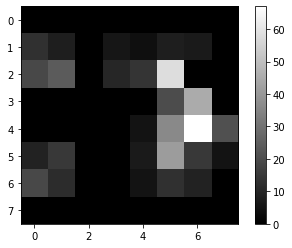

In [7]:
print('데이터 이미지화 확인')
plt.imshow(array_feature_train[1] , cmap='gray')
plt.colorbar();

# 2. 데이터 전처리
## (1) 이미지 데이터 증강

### 1) 이미지 리사이즈

In [8]:

print("사이즈 변경 전 이미지 크기: {}".format(array_feature_train[1].shape))
def image_upsize(array_feature, upsize_factor):
    
    SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1" 
    super_resolution_model = hub.load(SAVED_MODEL_PATH) # 3채널에서만 작동.
    tf_array_feature = tf.convert_to_tensor(array_feature)
    tf_array_feature = tf.cast(tf_array_feature, tf.float32) # uint8 -> float32
    upsized_array_feature = []
    for i, array in enumerate(tf_array_feature):
        
        # model은 3채널용이므로, 이미지를 1채널 -> 3채널로 확장
        temp_array = copy.deepcopy(array)
        temp_array = tf.expand_dims(temp_array, 2)
        temp_array = tf.expand_dims(temp_array, 0)
        temp_array_2 = copy.deepcopy(temp_array)
        temp_array_3 = copy.deepcopy(temp_array)
        temp_array = np.concatenate((temp_array, temp_array_2), axis = 3)
        temp_array = np.concatenate((temp_array, temp_array_3), axis = 3)
    
        # 업사이즈 적용
        if upsize_factor > 0:
            for i in range(upsize_factor):
                temp_array = super_resolution_model(temp_array) 
        
        # 3채널 -> 1채널로 복구
        upsized_temp_array = tf.squeeze(temp_array)
        grayscale_upsized_temp_array = (upsized_temp_array[:,:,0] + 
                                        upsized_temp_array[:,:,1] + upsized_temp_array[:,:,2])/3
        upsized_array_feature.append(grayscale_upsized_temp_array)

    return np.array(upsized_array_feature)

array_feature_train = image_upsize(array_feature_train, upsize_factor)
array_feature_test = image_upsize(array_feature_test, upsize_factor)

print("사이즈 변경 후 이미지 크기: {}".format(array_feature_train[1].shape))

사이즈 변경 전 이미지 크기: (8, 8)
사이즈 변경 후 이미지 크기: (8, 8)


### 2) 픽셀 클래스화

In [9]:
print("클래스에 정보를 저장하기 위해 reshape를 수행합니다.") 

print("변경 전 array_feature_train의 shape: ", array_feature_train.shape)
print("변경 전 array_feature_test의 shape: ", array_feature_test.shape)

reshaped_array_feature_train = array_feature_train.reshape(feature_train.shape[0],upsized_image_size**2)
reshaped_array_feature_test = array_feature_test.reshape(feature_test.shape[0],upsized_image_size**2)

print("\n변경 후 array_feature_train의 shape: ", reshaped_array_feature_train.shape)
print("변경 후 array_feature_test의 shape: ", reshaped_array_feature_test.shape)

클래스에 정보를 저장하기 위해 reshape를 수행합니다.
변경 전 array_feature_train의 shape:  (2160, 8, 8)
변경 전 array_feature_test의 shape:  (540, 8, 8)

변경 후 array_feature_train의 shape:  (2160, 64)
변경 후 array_feature_test의 shape:  (540, 64)


In [10]:
# 점과 점 사이의 거리 구하는 함수
def distance(x1, y1, x2, y2):
    result = math.sqrt( math.pow(x1 - x2, 2) + math.pow(y1 - y2, 2))
    return result

# 픽셀 정보 계산
def pixel_instance(reshaped_array_feature, image_size):
    
    # 픽셀 정보를 저장하는 클래스 선언
    class pixel:
        def __init__(self, x, y, raw_intensity):
            self.x = x
            self.y = y
            self.current_intensity = raw_intensity
            self.x_prev_intensity = 0         # 초기값 설정
            self.y_prev_intensity = 0         # 초기값 설정
            self.x_next_intensity = 0         # 초기값 설정
            self.y_next_intensity = 0         # 초기값 설정
            self.x_intensity_gradient = 0     # 초기값 설정
            self.y_intensity_gradient = 0     # 초기값 설정
            self.gradient_magnitude = 0       # 초기값 설정
            self.gradient_angle = 0           # 초기값 설정
            
            
            
    list_1storder_pixel = []
    list_2ndorder_pixel = []
    
    for row in range(len(reshaped_array_feature)): #  샘플 개수 x image_size x image_size 만큼의 길이
        for column, raw_intensity in enumerate(reshaped_array_feature[row]):
            pixel_info = pixel(None,None,None)
            pixel_info.x = column % image_size + 1    # 2차원 기준, x 좌표 부여. column_num으로 끊음.
            pixel_info.y = column // image_size + 1   # 2차원 기준, y 좌표 부여. column_num으로 끊음.
            pixel_info.current_intensity = raw_intensity        
    
            
            if pixel_info.x > 1: # x축 최소값 초과시 직전 픽셀 입력. 최소값이면 기본값 0 부여.
                pixel_info.x_prev_intensity = reshaped_array_feature[row][column-1]
            
            if pixel_info.x < image_size: # y축 최소값 초과시 직전 픽셀 입력. 최소값이면 기본값 0 부여.
                pixel_info.x_next_intensity = reshaped_array_feature[row][column+1]
                
            if pixel_info.y > 1: # x축 최대값 미달시 직후 픽셀 입력. 최대값이면 기본값 0 부여.
                pixel_info.y_prev_intensity = reshaped_array_feature[row][column - image_size]
                
            if pixel_info.y < image_size: # y축 최대값 미달시 직후 픽셀 입력. 최대값이면 기본값 0 부여.
                pixel_info.y_next_intensity = reshaped_array_feature[row][column + image_size]
        
            pixel_info.x_intensity_gradient = pixel_info.x_next_intensity - pixel_info.x_prev_intensity
            pixel_info.y_intensity_gradient = pixel_info.y_next_intensity - pixel_info.y_prev_intensity
            pixel_info.gradient_magnitude = distance(pixel_info.x_prev_intensity, pixel_info.y_prev_intensity, 
                                          pixel_info.x_next_intensity, pixel_info.y_next_intensity)
            if pixel_info.x_intensity_gradient == 0: # 예외처리
                pass
            else:
                pixel_info.gradient_angle = np.arctan(pixel_info.y_intensity_gradient/pixel_info.x_intensity_gradient)
                
            list_1storder_pixel.append(pixel_info)
        list_2ndorder_pixel.append(list_1storder_pixel)
        list_1storder_pixel = []
    
    return list_2ndorder_pixel

train_list_pixel = pixel_instance(reshaped_array_feature_train, upsized_image_size)
test_list_pixel = pixel_instance(reshaped_array_feature_test, upsized_image_size)

### 3) 원본 어레이 추출

In [11]:
def array_raw_intensity(list_pixel, image_size):
    list_1storder_raw_intensity = []
    list_2ndorder_raw_intensity = []
    for idx in range(len(list_pixel)):
        for _, pixel in enumerate(list_pixel[idx]):
    
            temp_raw_intensity = pixel.current_intensity
            list_1storder_raw_intensity.append(temp_raw_intensity)
            if len(list_1storder_raw_intensity) == image_size**2:
                list_2ndorder_raw_intensity.append(list_1storder_raw_intensity)
                list_1storder_raw_intensity = []
    
    array_raw_intensity = np.array(list_2ndorder_raw_intensity)
    array_raw_intensity = array_raw_intensity.reshape(len(list_pixel), image_size, image_size)
    return array_raw_intensity

train_array_raw_intensity = array_raw_intensity(train_list_pixel, upsized_image_size)
test_array_raw_intensity = array_raw_intensity(test_list_pixel, upsized_image_size)

### 4) 그래디언트 크기 어레이 추출

In [12]:
def array_gradient_magnitude(list_pixel, image_size):
    list_1storder_gradient_magnitude = []
    list_2ndorder_gradient_magnitude = []
    for idx in range(len(list_pixel)):
        for _, pixel in enumerate(list_pixel[idx]):
    
            temp_gradient_magnitude = pixel.gradient_magnitude
#             temp_gradient_magnitude = int(temp_gradient_magnitude/1023 * 255) # 스케일링: 구간 [0, 1023] -> [0, 255]
            list_1storder_gradient_magnitude.append(temp_gradient_magnitude)
            if len(list_1storder_gradient_magnitude) == image_size**2:
                list_2ndorder_gradient_magnitude.append(list_1storder_gradient_magnitude)
                list_1storder_gradient_magnitude = []
    
    array_gradient_magnitude = np.array(list_2ndorder_gradient_magnitude)
    array_gradient_magnitude = array_gradient_magnitude.reshape(len(list_pixel), image_size, image_size)
    return array_gradient_magnitude
    
train_array_gradient_magnitude = array_gradient_magnitude(train_list_pixel, upsized_image_size)
test_array_gradient_magnitude = array_gradient_magnitude(test_list_pixel, upsized_image_size)

### 5) 그래디언트 각도 어레이 추출

In [13]:
def array_gradient_angle(list_pixel, image_size):
    list_1storder_gradient_angle = []
    list_2ndorder_gradient_angle = []
    for idx in range(len(list_pixel)):
        for _, pixel in enumerate(list_pixel[idx]):
            
            temp_gradient_angle = pixel.gradient_angle
            temp_gradient_angle = int((temp_gradient_angle + math.pi/2)/math.pi * 255) # 스케일링: 구간 [-pi/2, pi/2] -> [0,255]
            list_1storder_gradient_angle.append(temp_gradient_angle)
            if len(list_1storder_gradient_angle) == image_size**2:
                list_2ndorder_gradient_angle.append(list_1storder_gradient_angle)
                list_1storder_gradient_angle = []
    
    array_gradient_angle = np.array(list_2ndorder_gradient_angle)
    array_gradient_angle = array_gradient_angle.reshape(len(list_pixel), image_size, image_size)
    return array_gradient_angle

train_array_gradient_angle = array_gradient_angle(train_list_pixel, upsized_image_size)
test_array_gradient_angle = array_gradient_angle(test_list_pixel, upsized_image_size)

### 6) 최대값 정보 추출

In [14]:
# 최대값 정보
def info_max_intensity(list_pixel, image_size):
    # 초기값 설정
    lt_max_intensity = 0
    lt_max_x_pos = 1
    lt_max_y_pos = 1
    
    rt_max_intensity = 0
    rt_max_x_pos = 8
    rt_max_y_pos = 8
    
    list_info_max_intensity = []
    for idx in range(len(list_pixel)):
        for _, pixel in enumerate(list_pixel[idx]):
        
            # 좌측 최대값
            if pixel.x <= upsized_image_size/2:   
                if pixel.current_intensity > lt_max_intensity:
                    lt_max_x_pos = pixel.x
                    lt_max_y_pos = pixel.y
                    lt_max_intensity = pixel.current_intensity
                    
            # 우측 최대값
            if pixel.x > upsized_image_size/2:        
                if pixel.current_intensity > rt_max_intensity:                
                    rt_max_x_pos = pixel.x
                    rt_max_y_pos = pixel.y
                    rt_max_intensity = pixel.current_intensity
            
            
            distance_max_intensity = distance(lt_max_x_pos, lt_max_y_pos, rt_max_x_pos, rt_max_y_pos)
            dict_max_intensity = {'lt_max_x_pos': lt_max_x_pos, 'lt_max_y_pos': lt_max_y_pos, 'lt_max_intensity': lt_max_intensity,
                                 'rt_max_x_pos': rt_max_x_pos, 'rt_max_y_pos': rt_max_y_pos, 'rt_max_intensity': rt_max_intensity,
                                 'distance_max_intensity': distance_max_intensity
                                 }
        list_info_max_intensity.append(dict_max_intensity) # 계산값 입력
        lt_max_intensity = 0   # 초기화
        rt_max_intensity = 0   # 초기화
    return list_info_max_intensity

train_list_info_max_intensity = info_max_intensity(train_list_pixel, upsized_image_size)
test_list_info_max_intensity = info_max_intensity(test_list_pixel, upsized_image_size)        

### 7) 최대 강도 어레이 추출

In [15]:
def array_max_intensity(list_info_max_intensity, image_size):
    
    list_max_intensity = []
    for idx in range(len(list_info_max_intensity)):
        zero_array = np.zeros(shape=(image_size, image_size), dtype=np.uint8)
        zero_array[list_info_max_intensity[idx]['lt_max_y_pos']-1,list_info_max_intensity[idx]['lt_max_x_pos']-1] = list_info_max_intensity[idx]['lt_max_intensity']
        zero_array[list_info_max_intensity[idx]['rt_max_y_pos']-1,list_info_max_intensity[idx]['rt_max_x_pos']-1] = list_info_max_intensity[idx]['rt_max_intensity']
        list_max_intensity.append(zero_array)
        
    array_max_intensity = np.array(list_max_intensity)
    return array_max_intensity

train_array_max_intensity = array_max_intensity(train_list_info_max_intensity, upsized_image_size)
test_array_max_intensity = array_max_intensity(test_list_info_max_intensity, upsized_image_size)

### 8) 필터 이미지 병합

In [16]:
# array_feature에 filter augmented data를 concatenate.
def filter_concat(array_feature, array_gradient_magnitude, array_gradient_angle, array_max_intensity,
                  blur_filter = False, contour_filter = False, edge_enhance_filter = False, 
                  gradient_magnitude_filter = False, gradient_angle_filter = False, max_intensity_filter = False):
    
    filteradded_array_feature = []
    
    for i, j in enumerate(array_feature):
        image = Image.fromarray(array_feature[i])
        stack_array = np.expand_dims(array_feature[i], axis = 2)
        
        if blur_filter:
            image_BLUR = image.filter(ImageFilter.BLUR)
            blur_array_feature = np.array(image_BLUR)
            blur_stack_array = np.expand_dims(blur_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, blur_stack_array), axis = 2)
            
        if contour_filter:
            image_CONTOUR = image.filter(ImageFilter.CONTOUR)
            contour_array_feature = np.array(image_CONTOUR)
            contour_stack_array = np.expand_dims(contour_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, contour_stack_array), axis = 2)
            
        if edge_enhance_filter:
            image_EDGE_ENHANCE = image.filter(ImageFilter.EDGE_ENHANCE)
            edge_enhance_array_feature = np.array(image_EDGE_ENHANCE)
            edge_enhance_stack_array = np.expand_dims(edge_enhance_array_feature, axis = 2)
            stack_array = np.concatenate((stack_array, edge_enhance_stack_array), axis = 2)
        
        if gradient_magnitude_filter:
            gradient_magnitude_stack_array = np.expand_dims(array_gradient_magnitude[i], axis = 2)
            stack_array = np.concatenate((stack_array, gradient_magnitude_stack_array), axis = 2)
            
        if gradient_angle_filter:
            gradient_angle_stack_array = np.expand_dims(array_gradient_angle[i], axis = 2)
            stack_array = np.concatenate((stack_array, gradient_angle_stack_array), axis = 2)  
        
        if max_intensity_filter:
            array_max_intensity_stack_array = np.expand_dims(array_max_intensity[i], axis = 2)
            stack_array = np.concatenate((stack_array, array_max_intensity_stack_array), axis = 2)    
        
        filteradded_array_feature.append(stack_array)
    
    filteradded_array_feature = np.array(filteradded_array_feature)
    return filteradded_array_feature
    

# 최종 특징 생성
final_feature_train = filter_concat(train_array_raw_intensity, train_array_gradient_magnitude, train_array_gradient_angle, 
                                    train_array_max_intensity, blur_filter = blur_filter, contour_filter = contour_filter, 
                                    edge_enhance_filter = edge_enhance_filter, gradient_magnitude_filter = gradient_magnitude_filter, 
                                    gradient_angle_filter = gradient_angle_filter, max_intensity_filter = max_intensity_filter)

print("최종 훈련 feature의 shape:", final_feature_train.shape)

final_feature_test = filter_concat(test_array_raw_intensity, test_array_gradient_magnitude, test_array_gradient_angle, 
                                    test_array_max_intensity, blur_filter = blur_filter, contour_filter = contour_filter, 
                                    edge_enhance_filter = edge_enhance_filter, gradient_magnitude_filter = gradient_magnitude_filter, 
                                    gradient_angle_filter = gradient_angle_filter, max_intensity_filter = max_intensity_filter)

print("최종 테스트 feature의 shape:", final_feature_test.shape)
print("증강이 적용된 필터의 개수는 {}개입니다.".format(filter_num))


# 특징 정규화   # 이미지 출력 단계에서 8비트 스케일링이 되어 있으므로, 255가 맞음.
local_X_train = tf.cast(final_feature_train, dtype = tf.float32) / 255.0  
local_X_test = tf.cast(final_feature_test, dtype = tf.float32) / 255.0   

최종 훈련 feature의 shape: (2160, 8, 8, 1)
최종 테스트 feature의 shape: (540, 8, 8, 1)
증강이 적용된 필터의 개수는 0개입니다.


# 3. 모델 학습

## (1) 모델 설계 및 대표 벡터 추출

### 1) 모델 설계

In [17]:
# ResNet 블럭 정의: ResNet-50 관련 블럭 삭제.
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,
                      ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        identity = x
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_1_conv{cnn_num}'
        )(x)

        identity_channel = identity.shape.as_list()[-1]    
        if identity_channel != channel:
            identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
        # skip connection
        x = keras.layers.Add()([x,identity])   

    identity_channel = identity.shape.as_list()[-1]    
    if identity_channel != channel:
        identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
    # skip connection
    x = keras.layers.Add()([x,identity])   

    # Max Pooling 레이어
    # 마지막 블록 뒤에는 pooling을 하지 않음
    if identity.shape[1] != 1:        
        x = keras.layers.MaxPooling2D(
            pool_size=(2, 2),
            strides=2,
            name=f'block{block_num}_pooling'
        )(x)

    return x

In [18]:
# ResNet-34 정의: ResNet-50 관련 블럭 삭제.
def build_resnet(input_shape=(upsized_image_size,upsized_image_size, filter_num+1),

                 num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
                ):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
      
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (2,2),
                       strides = 2,
                         padding = 'valid')(output)
    output = keras.layers.BatchNormalization()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (2,2),
                                      strides = 2,)(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )    
    output = keras.layers.AveragePooling2D(padding = 'same')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(512, activation='relu', name='fc1')(output)    
    output = keras.layers.Dense(classes_num, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

resnet_34_model = build_resnet()
resnet_34_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8, 8, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 4, 4, 64)     320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4, 4, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 2, 2, 64)     0           ['batch_normalization[0][0]']

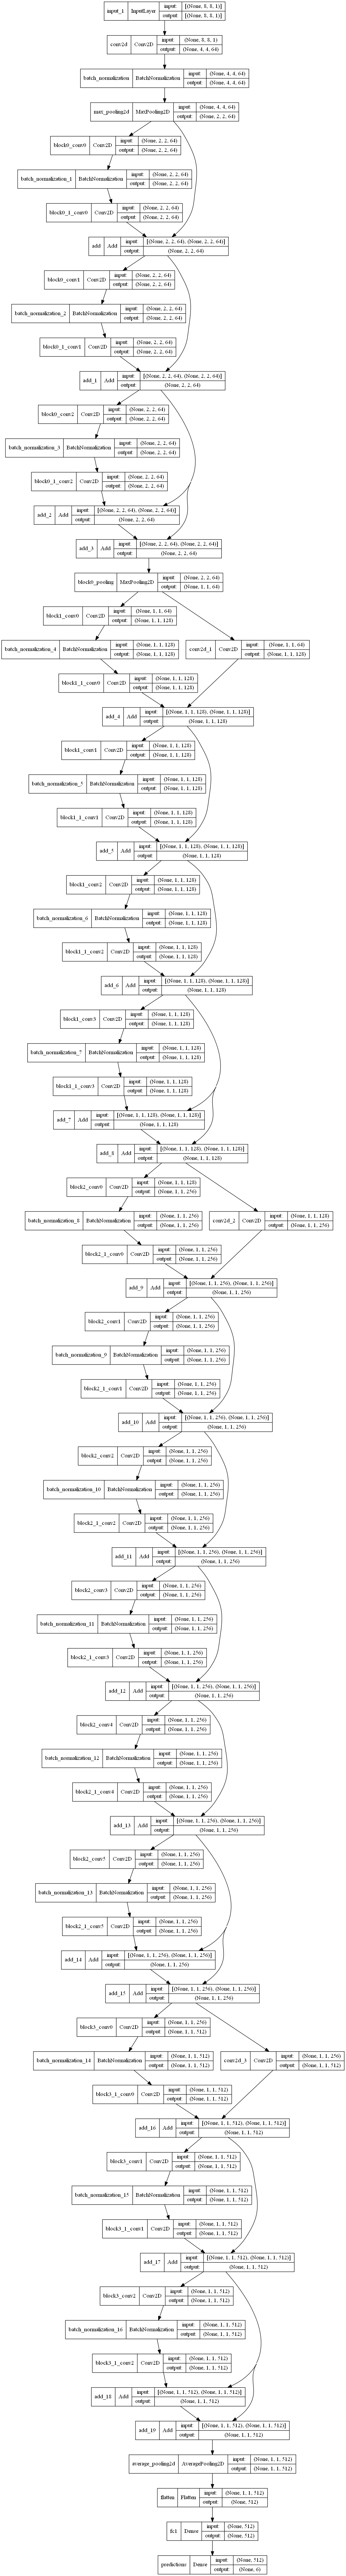

In [19]:
# 모델 도면 출력
plot_model(resnet_34_model, 'resnet_34_model.png', show_shapes = True)

### 2) 모델 학습

In [20]:
optimizer=SGD(learning_rate=learning_rate, clipnorm=1.)
resnet_34_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

history_34 = resnet_34_model.fit(   
    local_X_train, y_train,
    epochs = epoch_num,
    verbose=1,
    use_multiprocessing=True,
)

resnet_34_model.evaluate(local_X_test, y_test, verbose = 2)

Epoch 1/50
68/68 [==============================] - 8s 58ms/step - loss: nan - accuracy: 0.0028
Epoch 2/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/50
68/68 [==============================] - 4s 54ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/50
68/68 [==============================] - 4s 55ms/step - loss: nan - accuracy: 0.0000e+00
Epo

[nan, 0.0]

### 3) 대표 벡터 추출

In [21]:
# 모델의 전체 특징 리스트 확인
resnet_34_features_list = [layer.output for layer in resnet_34_model.layers]

# 전체 특징 추출
resnet_34_feat_extraction_model = Model(inputs = resnet_34_model.input, outputs = resnet_34_features_list)
train_resnet_34_extracted_features = resnet_34_feat_extraction_model(local_X_train)
test_resnet_34_extracted_features = resnet_34_feat_extraction_model(local_X_test)

# 대표 벡터 추출
train_resnet_34_representations = np.array(train_resnet_34_extracted_features[-1]) # 분류 단계의 직전 특징들
test_resnet_34_representations = np.array(test_resnet_34_extracted_features[-1])  # 분류 단계의 직전 특징들
print(type(train_resnet_34_representations))
print(train_resnet_34_representations.shape)

train_resnet_34_representations

<class 'numpy.ndarray'>
(2160, 6)


array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

## (2) 분류 예측

In [22]:
# K-Neighbors 
KN_classifier = KNeighborsClassifier(n_neighbors = 3, p=2, metric = 'minkowski')
KN_classifier.fit(train_resnet_34_representations, y_train)

# Decision tree
DT_classifier = DecisionTreeClassifier(random_state = classifier_random_state)   ## 모델 지정
DT_classifier.fit(train_resnet_34_representations, y_train)


# Random forest
RF_classifier = RandomForestClassifier(random_state = classifier_random_state)   ## 모델 지정
RF_classifier.fit(train_resnet_34_representations, y_train)


# Support vector machine
SVM_classifier = svm.SVC(random_state = classifier_random_state, kernel = 'linear', C = 10)   ## C가 클수록 정확해짐
SVM_classifier.fit(train_resnet_34_representations, y_train)


# Stochastic gradient descent
SGD_classifier = SGDClassifier(random_state = classifier_random_state)   ## 모델 지정
SGD_classifier.fit(train_resnet_34_representations, y_train)


# Logistic regression
LR_classifier = LogisticRegression(random_state = classifier_random_state, max_iter = 5000)   ## 모델 지정
LR_classifier.fit(train_resnet_34_representations, y_train)

# Multinomial Naive Bayes
MNB_classifier = MultinomialNB()   ## 모델 지정
MNB_classifier.fit(train_resnet_34_representations, y_train)


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
print('*** K-Neighbors classifier result ***')
KN_y_pred = KN_classifier.predict(test_resnet_34_representations)
KN_report = classification_report(y_test, KN_y_pred)
print(KN_report)

print('*** Decision tree classifier result ***')
DT_y_pred = DT_classifier.predict(test_resnet_34_representations)
DT_report = classification_report(y_test, DT_y_pred)
print(DT_report)

print('*** Random forest classifier result ***')
RF_y_pred = RF_classifier.predict(test_resnet_34_representations)
RF_report = classification_report(y_test, RF_y_pred)
print(RF_report)

print('*** Support vector machine classifier result ***')
SVM_y_pred = SVM_classifier.predict(test_resnet_34_representations)
SVM_report = classification_report(y_test, SVM_y_pred)
print(SVM_report)

print('*** Stochastic gradient descent classifier result ***')
SGD_y_pred = SGD_classifier.predict(test_resnet_34_representations)
SGD_report = classification_report(y_test, SGD_y_pred)
print(SGD_report)

print('*** Logistic regression classifier result ***')
LR_y_pred = LR_classifier.predict(test_resnet_34_representations)
LR_report = classification_report(y_test, LR_y_pred)
print(LR_report)

print('*** Multinomial Naive Bayes classifier result ***')
MNB_y_pred = MNB_classifier.predict(test_resnet_34_representations)
MNB_report = classification_report(y_test, LR_y_pred)
print(MNB_report)


## (3) 결과 시각화
### Confusion matrix

In [ ]:
# Confusion matrix 계산 및 히트맵 시각화

KN_cm = confusion_matrix(y_test, KN_y_pred)
DT_cm = confusion_matrix(y_test, DT_y_pred)
RF_cm = confusion_matrix(y_test, RF_y_pred)
SVM_cm = confusion_matrix(y_test, SVM_y_pred)
SGD_cm = confusion_matrix(y_test, SGD_y_pred)
LR_cm = confusion_matrix(y_test, LR_y_pred)
MNB_cm = confusion_matrix(y_test, MNB_y_pred)



sns.set(rc = {'figure.figsize':(15,15)})
fig, axes = plt.subplots(nrows = 4, ncols = 2)
sns.heatmap(KN_cm/np.sum(KN_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[0,0])
sns.heatmap(DT_cm/np.sum(DT_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[0,1])
sns.heatmap(RF_cm/np.sum(RF_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[1,0])
sns.heatmap(SVM_cm/np.sum(SVM_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[1,1])
sns.heatmap(SGD_cm/np.sum(SGD_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[2,0])
sns.heatmap(LR_cm/np.sum(LR_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[2,1])
sns.heatmap(MNB_cm/np.sum(MNB_cm), annot=True, fmt='.2%', cmap='Blues', ax = axes[3,0])
    

### TSNE

In [ ]:
# representation 벡터 형태 변환
train_df = pd.DataFrame(train_resnet_34_representations)

# 2차원 t-SNE 임베딩
tsne_np = TSNE(n_components = 2).fit_transform(train_df)

# numpy array -> DataFrame 변환
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

df_y = np.array(y_train)
df_y = pd.DataFrame(df_y)
tsne_df['target'] = pd.DataFrame(df_y)

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 0]
tsne_df_1 = tsne_df[tsne_df['target'] == 1]
tsne_df_2 = tsne_df[tsne_df['target'] == 2]
tsne_df_3 = tsne_df[tsne_df['target'] == 3]
tsne_df_4 = tsne_df[tsne_df['target'] == 4]
tsne_df_5 = tsne_df[tsne_df['target'] == 5]

In [ ]:
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = 'pink', label = 'CC')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = 'purple', label = 'MSJ')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = 'yellow', label = 'SDW')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = 'red', label = 'LJS')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], color = 'blue', label = 'LJJ')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], color = 'green', label = 'YHJ')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()
plt.savefig('tsne_sample.png')